# Brief Summary

**XGBoost**: Level-wise Tree Growth(Grows trees level by level)



*   Safer → less overfitting
*   Best Choice for Smaller(<100k rows) and Medium Dataset


*   Hyperparameter Tuning Complexity is medium giving stable and balanced models, but not optimal.

           Root
        /       \
     Level        Level

**LightGBM** → Leaf-wise Tree Growth




*   Splits best leaf first
*   Slightly better accuracy in:
Larget DatasetLarge (>1M rows) , High-dimensional data
*   Faster convergence
*   Can overfit on small datasets

        Root
           \
           Best Leaf
                \
               Best Leaf



In [4]:
# Install Latest Libraries
!pip install -U xgboost lightgbm optuna ydata-profiling sweetviz

In [5]:
import warnings
warnings.filterwarnings('ignore')
from collections import Counter

# Import necessary packages
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Load training and testing datasets
train = pd.read_csv("Titanic_train.csv")
test = pd.read_csv("Titanic_test.csv")

In [7]:
# Create a working copy of training data
df = train.copy()

In [8]:
# Display first 5 rows
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# Dataset structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
# Statistical summary
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [11]:
# Check duplicate rows
df.duplicated().sum()

np.int64(0)

In [12]:
# Visualize missing values percentage
(df.isnull().mean() * 100).sort_values(ascending=False)

,0
Cabin,77.104377
Age,19.865320
Embarked,0.224467
PassengerId,0.000000
Name,0.000000
Pclass,0.000000
Survived,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000


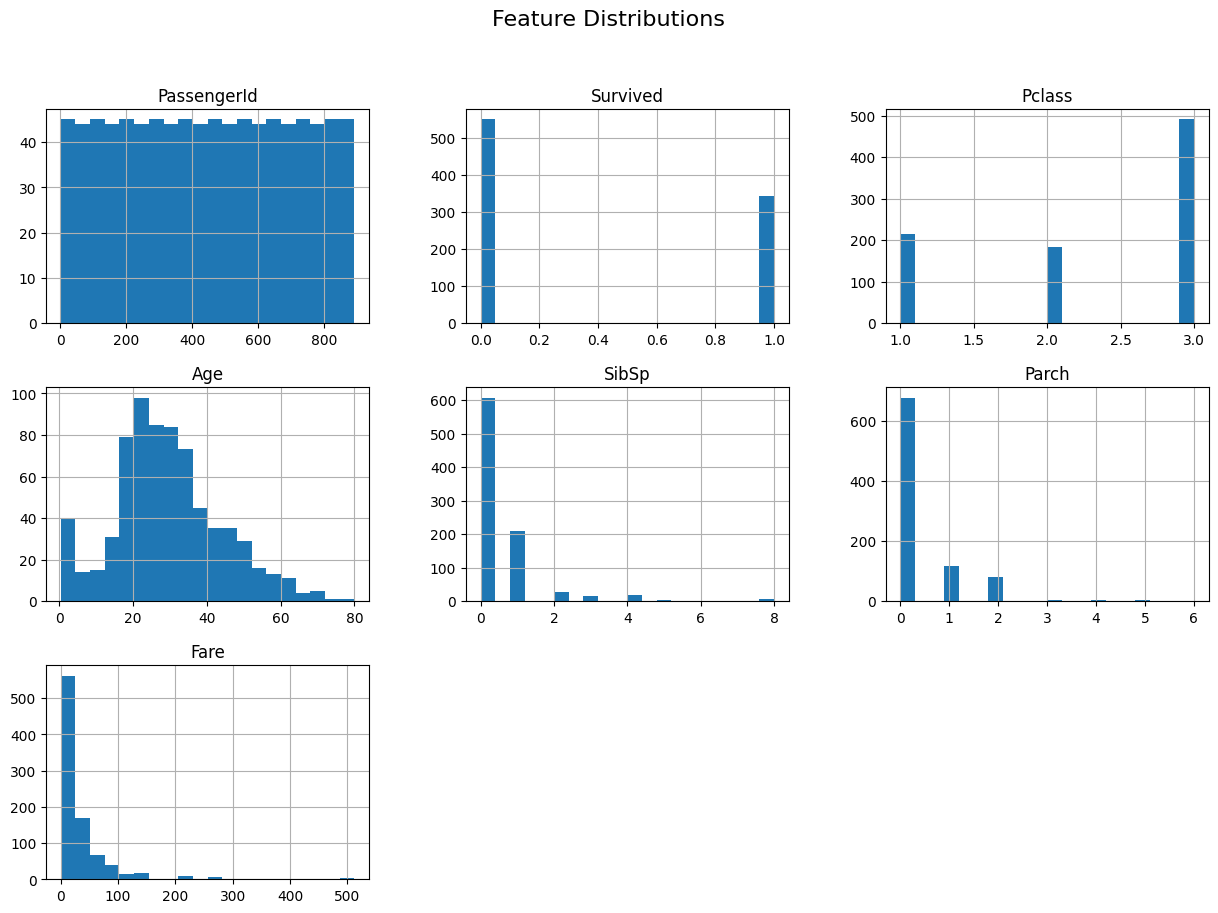

In [13]:
# Histograms
df.hist(bins=20, figsize=(15,10))
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

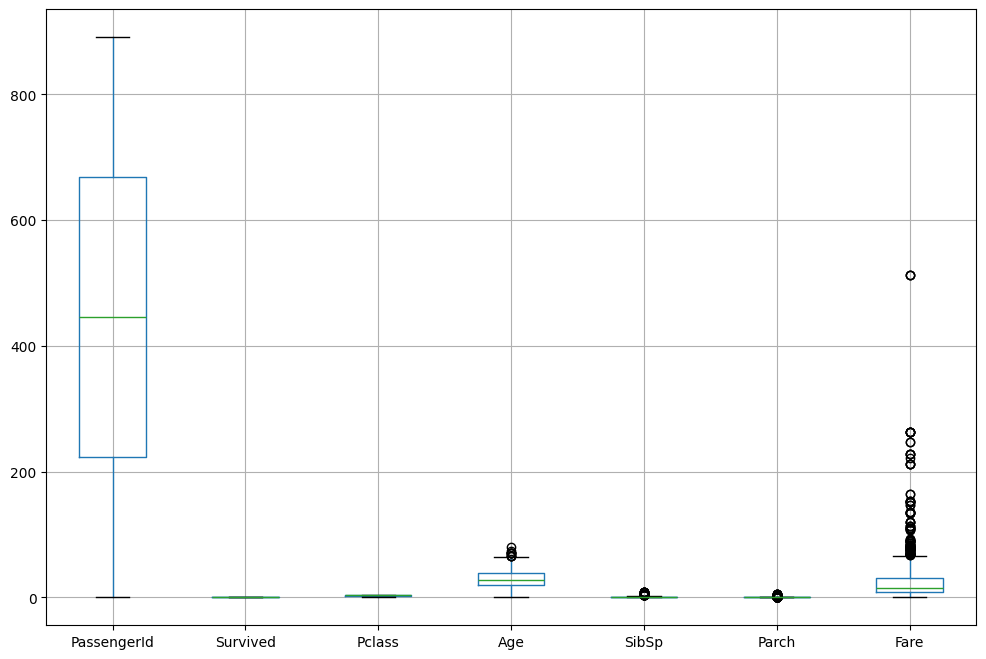

In [14]:
# outliers detected
df.boxplot(figsize=(12,8))
plt.show()

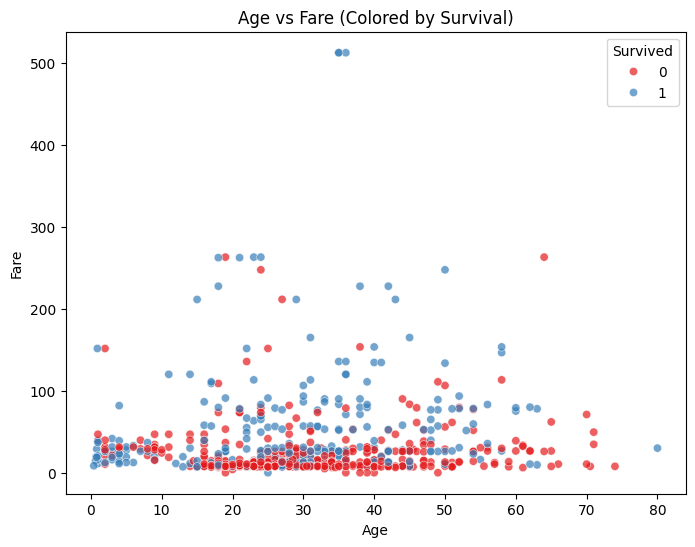

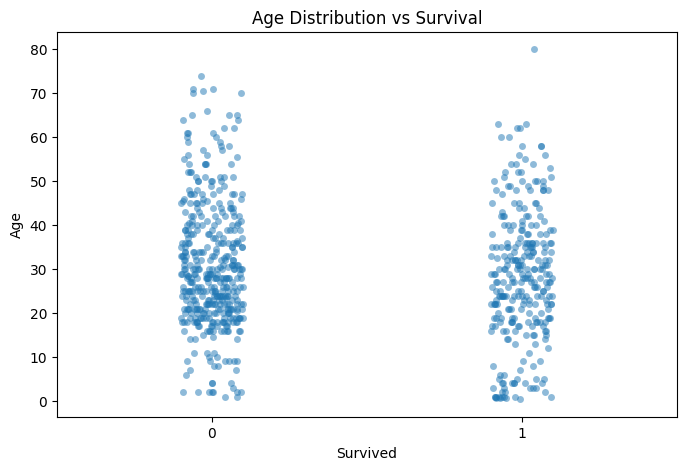

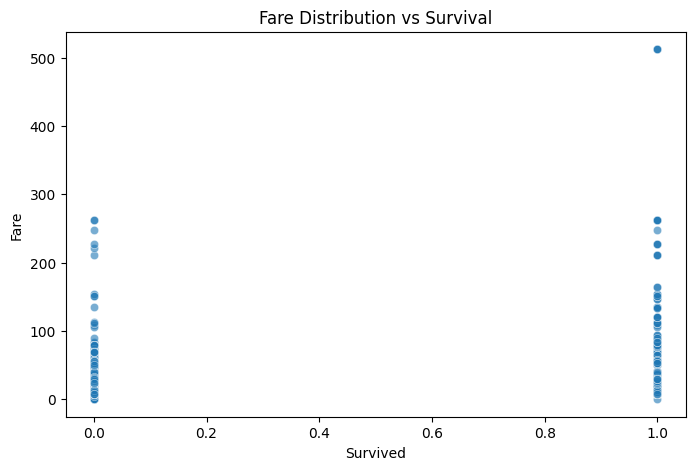

In [15]:
# Scatter Age vs Fare

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df,
    x='Age',
    y='Fare',
    hue='Survived',
    palette='Set1',
    alpha=0.7
)
plt.title("Age vs Fare (Colored by Survival)")
plt.show()

#Age vs Survial

plt.figure(figsize=(8,5))
sns.stripplot(
    x='Survived',
    y='Age',
    data=df,
    jitter=True,
    alpha=0.5
)
plt.title("Age Distribution vs Survival")
plt.show()

# Fare vs Survival

plt.figure(figsize=(8,5))
sns.scatterplot(
    x='Survived',
    y='Fare',
    data=df,
    alpha=0.6
)
plt.title("Fare Distribution vs Survival")
plt.show()

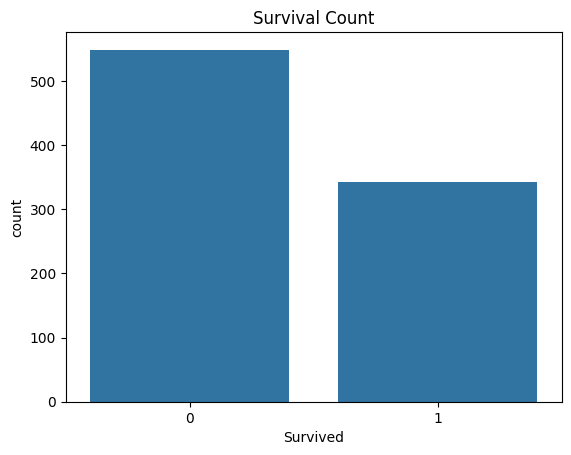

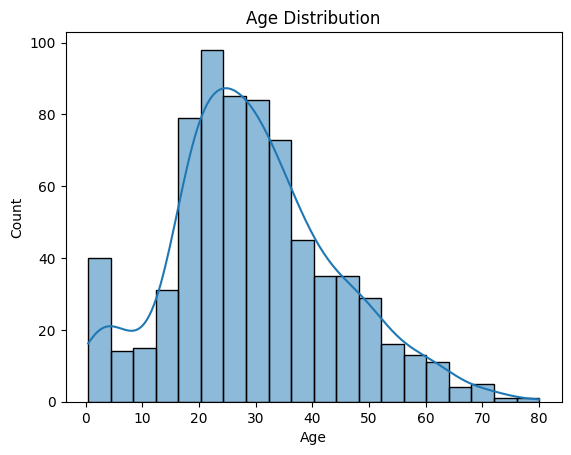

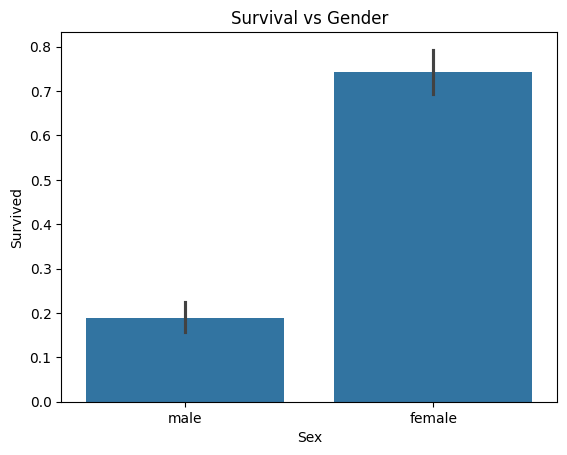

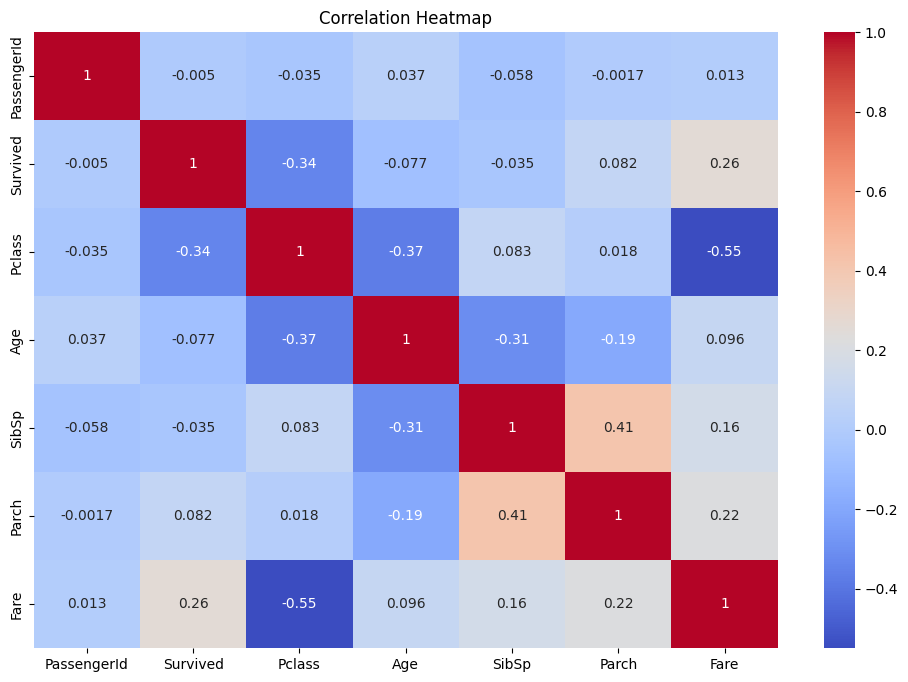

In [16]:
# Survival distribution
sns.countplot(x='Survived', data=df)
plt.title('Survival Count')
plt.show()

# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Survival vs Gender
sns.barplot(x='Sex', y='Survived', data=df)
plt.title('Survival vs Gender')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Handling Missing Values

In [17]:
# Drop high-missing column
df.drop(columns=['Cabin'], inplace=True)
test.drop(columns=['Cabin'], inplace=True)

# Impute Age
df['Age'].fillna(df['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)

# Impute Embarked
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)

In [18]:
df.isnull().sum() # verify all Null values removed

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [19]:
# Fix Fare skew using log transform
# Example before 5,50,200 after: 1.79,3.92,6.22
df['Fare'] = np.log1p(df['Fare'])
test['Fare'] = np.log1p(test['Fare'])

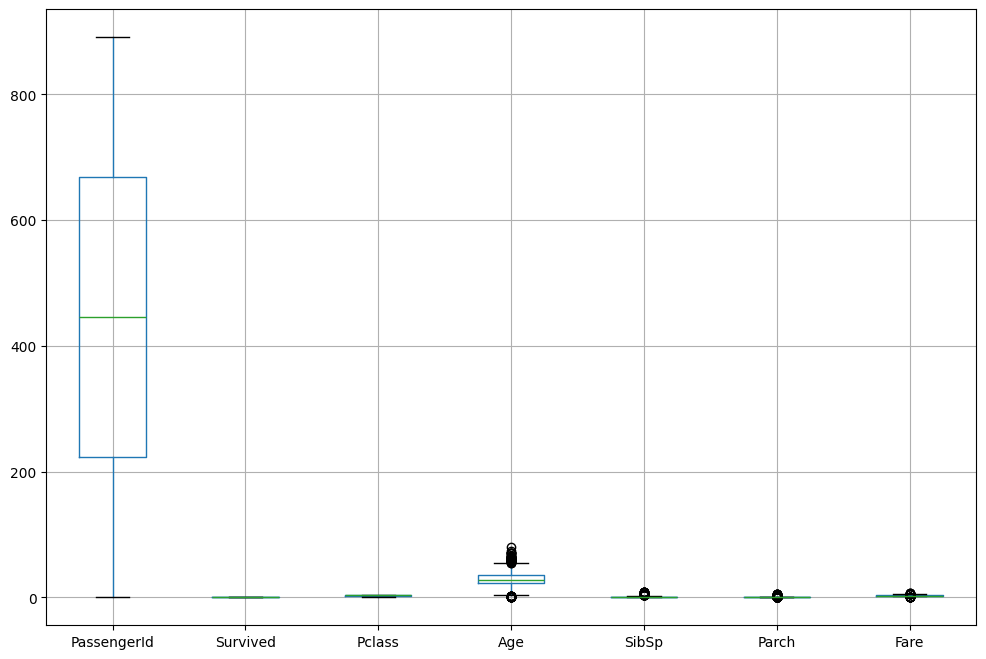

In [20]:
# outliers in age are kept because age directly influences survival probability
df.boxplot(figsize=(12,8))
plt.show()

In [21]:
# Imports

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [22]:
# Drop non-useful columns
drop_cols = ['PassengerId','Name','Ticket']
X = df.drop(['Survived'] + drop_cols, axis=1)
y = df['Survived']

In [23]:
# Identify feature types
num_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

print("Numerical Features:", num_features)
print("Categorical Features:", cat_features)

Numerical Features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
Categorical Features: ['Sex', 'Embarked']


In [24]:
preprocessor_ohe = ColumnTransformer([('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())]), num_features),

                   ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))]), cat_features)
])

In [25]:
label_encoders = {}

for col in cat_features:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

In [26]:
X_processed = preprocessor_ohe.fit_transform(X)
X_processed

array([[ 0.        , -0.46153846,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-2.        ,  0.76923077,  1.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        , -0.15384615,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.        ,  0.        ,  1.        , ...,  0.        ,
         0.        ,  1.        ],
       [-2.        , -0.15384615,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.30769231,  0.        , ...,  0.        ,
         1.        ,  0.        ]])

Building Predictive Model

In [27]:
# Imports
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# ML models
import lightgbm as lgb
import xgboost as xgb

# Hyperparameter optimization
import optuna

In [28]:
# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, stratify=y, random_state=42)

In [29]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(712, 10)
(179, 10)
(712,)
(179,)


LightGBM Model

In [30]:
lgb_model = lgb.LGBMClassifier(
n_estimators=300,
learning_rate=0.05,
max_depth=6,
random_state=42
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 209
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

LGBMClassifier(learning_rate=0.05, max_depth=6, n_estimators=300,
               random_state=42)

In [31]:
lgb_preds = lgb_model.predict(X_test)
lgb_preds

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0])

XGBoost Model

In [32]:
xgb_model = xgb.XGBClassifier(
n_estimators=300,
learning_rate=0.05,
max_depth=6,
subsample=0.8,
colsample_bytree=0.8,
eval_metric='logloss',
random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [33]:
xgb_preds = xgb_model.predict(X_test)
xgb_preds

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 0])

Evaluation Metrics:

In [34]:
lgb_acc = accuracy_score(y_test, lgb_preds)
xgb_acc = accuracy_score(y_test, xgb_preds)

lgb_prec = precision_score(y_test, lgb_preds)
xgb_prec = precision_score(y_test, xgb_preds)

lgb_rec = recall_score(y_test, lgb_preds)
xgb_rec = recall_score(y_test, xgb_preds)

lgb_f1 = f1_score(y_test, lgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds)

print("LightGBM Metrics:", lgb_acc, lgb_prec, lgb_rec, lgb_f1)
print("XGBoost Metrics:", xgb_acc, xgb_prec, xgb_rec, xgb_f1)

LightGBM Metrics: 0.7877094972067039 0.7540983606557377 0.6666666666666666 0.7076923076923077
XGBoost Metrics: 0.7988826815642458 0.7619047619047619 0.6956521739130435 0.7272727272727273


Confusion Matrix:

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

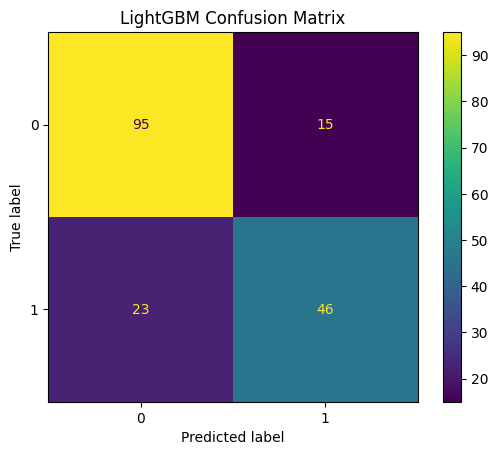

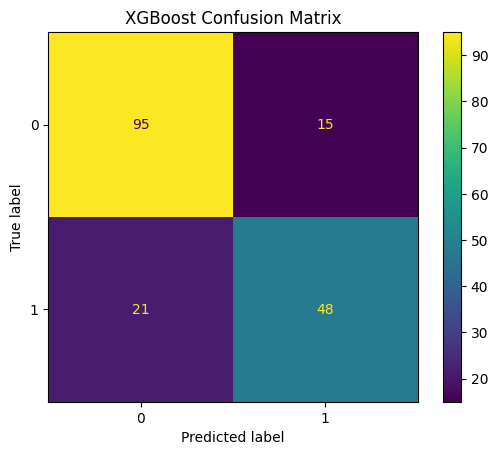

In [36]:
ConfusionMatrixDisplay(confusion_matrix(y_test, lgb_preds)).plot()
plt.title('LightGBM Confusion Matrix')
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, xgb_preds)).plot()
plt.title('XGBoost Confusion Matrix')
plt.show()


Cross-Validation

In [37]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lgb_cv = cross_val_score(lgb_model, X_processed, y, cv=cv, scoring='accuracy')
xgb_cv = cross_val_score(xgb_model, X_processed, y, cv=cv, scoring='accuracy')

print("LightGBM CV Accuracy:", lgb_cv.mean())
print("XGBoost CV Accuracy :", xgb_cv.mean())

[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Hyperparameter Tuning:

Optuna Trial
    ↓

Sample Hyperparameters
    ↓

Train XGBoost
    ↓

3-Fold Cross Validation
    ↓

Return Accuracy
    ↓

Optuna learns which regions perform better




In [38]:
# Function that Optuna will optimize
def objective(trial):

    # Define hyperparameter ranges for XGBoost
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 300, 1200),   # number of trees
        "max_depth": trial.suggest_int("max_depth", 3, 10),              # tree depth
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),# step size
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),         # row sampling
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0) # feature sampling
    }

    # Create model with sampled parameters
    model = xgb.XGBClassifier(**params, eval_metric='logloss', random_state=42)

    # Evaluate model using 3-fold cross-validation
    # Return mean accuracy
    return cross_val_score(model, X_processed, y, cv=3, scoring='accuracy').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40) # optimization for 40 trials

study.best_params # result


[I 2026-02-07 14:22:15,072] A new study created in memory with name: no-name-673590ba-cbd9-4914-9542-d33dc99934e8
[I 2026-02-07 14:22:18,086] Trial 0 finished with value: 0.8125701459034792 and parameters: {'n_estimators': 690, 'max_depth': 6, 'learning_rate': 0.04685573214669939, 'subsample': 0.7916578359962568, 'colsample_bytree': 0.7238749006331339}. Best is trial 0 with value: 0.8125701459034792.
[I 2026-02-07 14:22:20,193] Trial 1 finished with value: 0.7979797979797979 and parameters: {'n_estimators': 1072, 'max_depth': 5, 'learning_rate': 0.060119677201812466, 'subsample': 0.8666401774184054, 'colsample_bytree': 0.8910924274519505}. Best is trial 0 with value: 0.8125701459034792.
[I 2026-02-07 14:22:20,766] Trial 2 finished with value: 0.8114478114478114 and parameters: {'n_estimators': 594, 'max_depth': 7, 'learning_rate': 0.05120185449164112, 'subsample': 0.6517506272809821, 'colsample_bytree': 0.6783993070105672}. Best is trial 0 with value: 0.8125701459034792.
[I 2026-02-07 

{'n_estimators': 528,
 'max_depth': 7,
 'learning_rate': 0.01291229288100185,
 'subsample': 0.7415981200812393,
 'colsample_bytree': 0.6563666399926347}

Comparative Analysis: Visualization + Interpretation

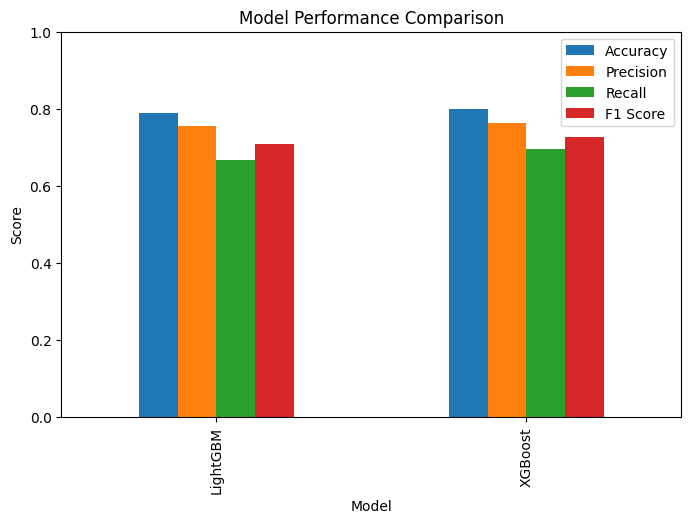

In [39]:
# Metric Comparison Bar Chart
metrics_df = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost'],
    'Accuracy': [lgb_acc, xgb_acc],
    'Precision': [lgb_prec, xgb_prec],
    'Recall': [lgb_rec, xgb_rec],
    'F1 Score': [lgb_f1, xgb_f1]
})

metrics_df.set_index('Model').plot(kind='bar', figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.show()

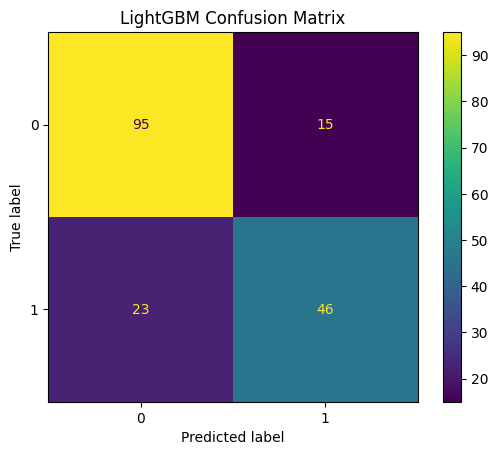

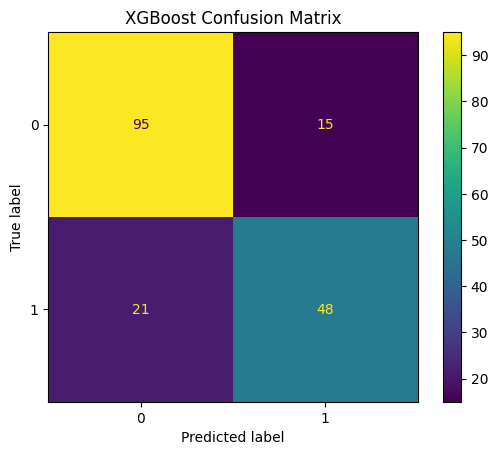

In [40]:
# Confusion Matrix Visual

from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, lgb_preds)
plt.title("LightGBM Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_test, xgb_preds)
plt.title("XGBoost Confusion Matrix")
plt.show()

#Comparative Analysis Report:

`In this study`, LightGBM and XGBoost algorithms were applied to the Titanic survival prediction problem. After preprocessing and feature engineering, both models were trained and evaluated using accuracy, precision, recall, and F1-score.

XGBoost achieved slightly higher accuracy and F1-score, indicating better predictive performance, particularly in identifying surviving passengers. LightGBM demonstrated faster training time and competitive performance, making it suitable for large-scale datasets.

Cross-validation results confirmed the stability of both models, while hyperparameter tuning further improved performance. Overall, XGBoost proved to be more accurate, whereas LightGBM offered better computational efficiency.

`Practical Implication:` For real-time or large-scale applications, LightGBM is preferable due to speed, while XGBoost is ideal when maximum prediction accuracy is required.